In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import corner

In [36]:
import os
from mmms import (utils, plot, io)
from mmms.br2016 import (br2016_mmax_scaling, br2016_max_spin)
from mmms.engine import (average_importance_sampling_weight, importance_sampling_weight)
from mmms.utils import bounds

MIN_BINS = 10
MAX_BINS = 50

TICK_PARAMS = {
    'left' : True,
    'right' : True,
    'top' : True,
    'bottom' : True,
    'direction' : 'in',
    'which' : 'both',
}

def hist2d_axes(fig):
    """generate axes for a 2D histogram
    """
    low, mid, high = 0.1, 0.75, 0.95

    ax = fig.add_axes([low, low, mid-low, mid-low])
    axm = fig.add_axes([low, mid, mid-low, high-mid]) 
    axs = fig.add_axes([mid, low, high-mid, mid-low]) 

    for a in [ax, axm, axs]:
        a.tick_params(**TICK_PARAMS)

    return ax, axm, axs


def hist(
        ax,
        samples,
        weights=None,
        label=None,
        color='k',
        alpha=1.0,
        linestyle='solid',
        orientation='vertical',
        binscale=0.5,
    ):
    """make a 1D histogram of weighed samples
    """
    if weights is None:
        weights = np.ones(len(samples), dtype=float)/len(samples)

    samples = samples[weights>0]
    weights = weights[weights>0]

#    lim, (m, M) = bounds(samples, weights)
    lim, _ = bounds(samples, weights)
    m, M = lim

    bins = np.linspace(m, M, min(MAX_BINS, max(MIN_BINS, int(binscale*len(samples)**0.5))))

    weights = weights[:] / np.sum(weights) ### make sure they're normalized
    weights /= bins[1]-bins[0]             ### normalize the scale height

    ans = ax.hist(
        samples,
        bins=bins,
        weights=weights,
        label=label,
        color=color,
        alpha=alpha,
        linestyle=linestyle,
        histtype='step',
        orientation=orientation,
    )
    if orientation == 'horizontal':
        ax.set_ylim(lim)
    elif orientation == 'vertical':
        ax.set_xlim(lim)
    else:
        raise ValueError('orientation=%s not understood!'%orientation)

    ax.tick_params(**TICK_PARAMS)

    return ans, lim

def hist2d(ax, x, y, weights=None, colormap='Blues', binscale=0.25):
    """make a 2D histogram of weighed samples
    """
    N = len(x)
    assert N==len(y), 'x and y  must be the same length'

    if weights is None:
        weights = np.ones(len(x), dtype=float)/len(x)
    else:
        assert N==len(weights), 'weights must be the same length as x and y'

    xlim, (xm, xM) = bounds(x, weights)
    ylim, (ym, yM) = bounds(y, weights)

    nbins = min(MAX_BINS, max(MIN_BINS, int(binscale*N**0.5)))
    xbins = np.linspace(xm, xM, nbins)
    ybins = np.linspace(ym, yM, nbins)

    weights = weights[:] / np.sum(weights)
    weights /= (xbins[1]-xbins[0])*(ybins[1]-ybins[0])

    ans = ax.hist2d(
        x,
        y,
        bins=[xbins, ybins],
        weights=weights,
        cmap=colormap,
    )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ### FIXME: add a colorbar?

    return ans, xlim, ylim

In [44]:
mix_population_samples2 = "../../grid_beta_low_NS_EOS/eos_population_mixtures/LEC-2020_population-1.0.csv.gz"
mix_population_samples1 = "../../grid_beta_low_NS_EOS/eos_population_mixtures/LEC-2020_population5.0.csv.gz"


# population_config = "LVK-O3-230529-PDB.ini"
population_config1 = "dist.ini"
population, pop_params, pop_variates = io.load_population(population_config1, verbose=False)

# population_samples = "LEC-2020_Updated-LVK-O3-sans-230529-PDB-forced.csv.gz"
population_samples = mix_population_samples2
pop_weight_column = "logweight_PSR_GW"
pop_weight_is_log = True
mtov_column = "Mmax"
rtov_column = "Rmax"
mtov_range = None
pop_max_num_samples = 500

pop_samples, pop_weights = io.load_population_samples(
    population_samples,
    weight_column=pop_weight_column,
    weight_column_is_log=pop_weight_is_log,
    mtov_column_range=(mtov_column, mtov_range) if mtov_range is not None else None,
    max_num_samples=pop_max_num_samples,
    verbose=True,
    retain=pop_params+(mtov_column, rtov_column),
)

mtov = pop_samples[mtov_column]
if rtov_column is not None:
    rtov = pop_samples[rtov_column]
else:
    rtov = None

pop_samples = io._downselect(pop_samples, pop_params)
# utils.report_samples2stats(utils.samples2stats(mtov, weights=pop_weights))

m1_column = "mass1_source"
m2_column = "mass2_source"
d_column = "luminosity_distance"
m_range = [0.0, 100.0]
mc_range = [0.0, 20.0]
q_range = [0.0, 1.0]
d_range = [0.0, 10000.0]

sample_ranges = [
    (m1_column, (lambda x: x[m1_column]), m_range),
    (m2_column, (lambda x: x[m2_column]), m_range),
    ('chirp mass', (lambda x: (x[m1_column]*x[m2_column])**0.6/(x[m1_column]+x[m2_column])**0.2), mc_range),
    ('mass ratio', (lambda x: x[m2_column]/x[m1_column]), q_range),
    (d_column, (lambda x: x[d_column]), d_range),
]

event_samples = "../../samples/GW230529_Combined_PHM_highSpin.csv.gz"
prior_column = "logprior"
prior_is_log = True
event_weight_column = None
event_weight_is_log = False
event_max_num_samples = 10000
mass_column = "mass1_source"
spin_column = "spin1_magnitude"

post_samples, post_priors, post_weights = io.load_event_samples(
    event_samples,
    prior_column,
    prior_column_is_log=prior_is_log,
    weight_column=event_weight_column,
    weight_column_is_log=event_weight_is_log,
    ranges=sample_ranges,
    max_num_samples=event_max_num_samples,
    verbose=True,
    retain=pop_variates+(mass_column, spin_column),
)

io.check_samples(population, post_samples) 

samples = post_samples
mass = post_samples[mass_column]
spin = post_samples[spin_column]
priors = post_priors
weights = post_weights

mass_ratio = []
spin_ratio = []
sample_weights = []


# iterate over population so we can compute importance sampling weights
for M, R, POP, W in zip(mtov, rtov, pop_samples, pop_weights):
    mass_ratio.append(mass/br2016_mmax_scaling(spin, M, R))
    spin_ratio.append(spin/br2016_max_spin(M, R))
    sample_weights.append(importance_sampling_weight(population, POP, samples, priors, weights) * W)

mass_ratio = np.concatenate(tuple(mass_ratio))
spin_ratio = np.concatenate(tuple(spin_ratio))
sample_weights = np.concatenate(tuple(sample_weights))

np.savez_compressed("mmms_mass_spin_weights2.npz",
                    samples=samples,
                    mass=mass,
                    spin=spin,
                    priors=priors,
                    weights=weights,
                    mass_ratio=mass_ratio,
                    spin_ratio=spin_ratio,
                    sample_weights=sample_weights)

/fs/lustre/scratch/mali/gw-distributions/gwdistributions/utils/cosmology.py:178: RuntimeWarning: divide by zero encountered in log
  return be.log(4*be.pi) + 2*be.log(Dc) + be.log(self.dDcdz(z))


loading samples from : ../../grid_beta_low_NS_EOS/eos_population_mixtures/LEC-2020_population-1.0.csv.gz
current number of samples (500000) is less than or equal to the maximum requested (inf)
downsampling from 500000 -> 500 samples
extracting nontrival weights from column=logweight_PSR_GW
    exponentiating weights
loading samples from : ../../samples/GW230529_Combined_PHM_highSpin.csv.gz
current number of samples (23988) is less than or equal to the maximum requested (inf)
pruning mass1_source samples to fit within [0.000000, 100.000000]
pruning mass2_source samples to fit within [0.000000, 100.000000]
pruning chirp mass samples to fit within [0.000000, 20.000000]
pruning mass ratio samples to fit within [0.000000, 1.000000]
pruning luminosity_distance samples to fit within [0.000000, 10000.000000]
    retained 23988 / 23988 samples
downsampling from 23988 -> 10000 samples
extracting nontrival weights from column=logprior
    exponentiating weights


In [ ]:
# tag = "reproducing_figure"

# #---

# ### now plot a basic histogram
# fig = plt.figure()
# ax, axm, axs = hist2d_axes(fig)
# binscale = 0.05

# # plot projected histogram of mass ratios
# hist(
#     axm,
#     mass_ratio,
#     weights=sample_weights,
#     color='b',
#     alpha=1.0,
#     linestyle='solid',
#     orientation='vertical',
#     binscale=binscale,
# )

# # plot projected histogram of spin ratios
# hist(
#     axs,
#     spin_ratio,
#     weights=sample_weights,
#     color='b',
#     alpha=1.0,
#     linestyle='solid',
#     orientation='horizontal',
#     binscale=binscale,
# )

# # plot the joint distribution
# _, (xmin, xmax), (ymin, ymax) = hist2d(
#     ax,
#     mass_ratio,
#     spin_ratio,
#     weights=sample_weights,
#     colormap='Blues',
#     binscale=binscale,
# )

# # draw shading and reference lines
# if (xmin < 1) and (1 < xmax) and (ymin < 1) and (1 < ymax):
#     ax.fill_between(
#         [xmin, 1.0, 1.0, xmax],
#         [1, 1, 0, 0],
#         [ymax, ymax, ymax, ymax],
#         color='k',
#         alpha=0.25,
#     )

# elif (xmin < 1) and (1 < xmax):
#     ax.fill_between([1, xmax], [ymin]*2, [ymax]*2, color='k', alpha=0.25)

# elif (ymin < 1) and (1 < ymax):
#     ax.fill_between([xmin, xmax], [1, 1], [ymax]*2, color='k', alpha=0.25)

# if (xmin < 1) and (1 < xmax):
#     ylim = axm.get_ylim()
#     axm.plot([1]*2, ylim, color='k')
#     axm.set_ylim(ylim)

# if (ymin < 1) and (1 < ymax):
#     xlim = axs.get_xlim()
#     axs.plot(xlim, [1.0]*2, color='k')
#     axs.set_xlim(xlim)

# ax.set_xlim(xmin=xmin, xmax=xmax)
# ax.set_ylim(ymin=ymin, ymax=ymax)

# axm.set_xlim(ax.get_xlim())
# axs.set_ylim(ax.get_ylim())

# ### finish decorating
# ax.set_xlabel('$m/M_\mathrm{max}(M_\mathrm{TOV}, R_\mathrm{TOV}, |a|)$')
# ax.set_ylabel('$|a|/a_\mathrm{max}(M_\mathrm{TOV}/R_\mathrm{TOV})$')

# for _ in [axm, axs]:
#     plt.setp(_.get_xticklabels(), visible=False)
#     plt.setp(_.get_yticklabels(), visible=False)

# plt.savefig("test.png")

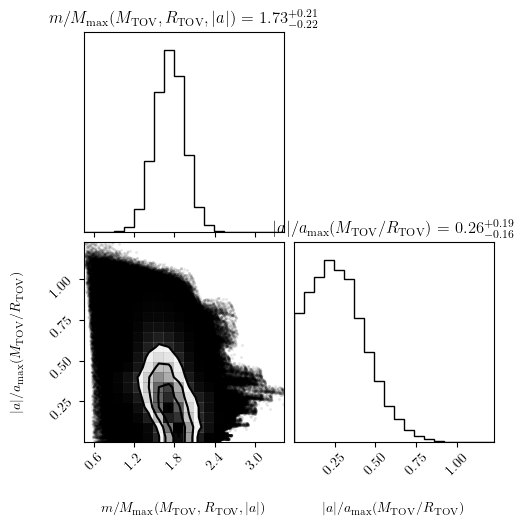

In [45]:
df = np.load("mmms_mass_spin_weights2.npz")

data = np.vstack([df["mass_ratio"], df["spin_ratio"]]).T
xlab = '$m/M_\mathrm{max}(M_\mathrm{TOV}, R_\mathrm{TOV}, |a|)$'
ylab = '$|a|/a_\mathrm{max}(M_\mathrm{TOV}/R_\mathrm{TOV})$'
fig = corner.corner(data, weights=df["sample_weights"], labels=[xlab, ylab], show_titles=True)
plt.savefig("reproduce.png")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Load data
df = np.load("mmms_mass_spin_weights.npz")
x = df["mass_ratio"]
y = df["spin_ratio"]
weights = df["sample_weights"]

# Labels
xlab = '$m/M_\\mathrm{max}(M_\\mathrm{TOV}, R_\\mathrm{TOV}, |a|)$'
ylab = '$|a|/a_\\mathrm{max}(M_\\mathrm{TOV}/R_\\mathrm{TOV})$'

# Create figure with GridSpec
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1.2], height_ratios=[1.2, 4], hspace=0.0, wspace=0.0)

# Lower left: 2D histogram (scatter with contour style)
ax_main = fig.add_subplot(gs[1, 0])
hb = ax_main.hist2d(x, y, bins=50, weights=weights, cmap='Blues')
ax_main.set_xlabel(xlab)
ax_main.set_ylabel(ylab)

# Bottom right: Y histogram
ax_yhist = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_yhist.hist(y, bins=20, orientation='horizontal', weights=weights, color='steelblue')
ax_yhist.tick_params(labelleft=False)
ax_yhist.set_xlabel("count")
ax_yhist.set_xlim(left=0)

# Top left: X histogram
ax_xhist = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_xhist.hist(x, bins=20, weights=weights, color='steelblue')
ax_xhist.tick_params(labelbottom=False)
ax_xhist.set_ylabel("count")
ax_xhist.set_ylim(top=ax_xhist.get_ylim()[1]*1.1)

# Top right is empty
fig.add_subplot(gs[0, 1]).axis('off')

# Save and show
plt.savefig("reproduce_gridspec.png", bbox_inches="tight", dpi=300)
plt.show()
